## Get the normalized merged data

In [2]:
from make_df import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors,tree
import matplotlib.pyplot as plt
np.random.seed(1234)
from sklearn.metrics import mean_squared_error,accuracy_score
from math import sqrt


PROJ_DIR = os.path.dirname(os.getcwd())


#Get the merged data(grouped by date)
merged_date,_ =normalize_and_scale_df(merge_dfs(), "date")
#Fill Nans with 0's for now(reset index on grouped by date data)
merged_new_date = merged_date.reset_index().fillna(0)



#Get the merged data(grouped by region)
merged_region,_ =normalize_and_scale_df(merge_dfs(), "region")
#Fill Nans with 0's for now(reset index on grouoed by region data)
merged_new_region = merged_region.reset_index().fillna(0)



## Elbow method to tune K

In [85]:
def knn_elbow(x_train_array,x_test_array, y_train_array,y_test_array, title="title missing"):
    #Calculate the mean squared error.
    rmse = [] 
    for k in range(1,50):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k)
        knn.fit(x_train_array,y_train_array)
        prediction = knn.predict(x_test_array)
        rmse.append((mean_squared_error(y_test_array, prediction)))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,50),rmse,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('Mean Squared Error')
    plt.figtext(.02, .02, "Training set used : " + title)
    plt.savefig(os.path.join(PROJ_DIR, 'figures',"knn_date"))
    plt.show()

In [86]:
def knn_visualize(x_train_array,x_test_array, y_train_array,y_test_array):
    neighbours = range(1,50)
    error_train = []
    error_test = []
    for i, k in enumerate(neighbours):
        model = neighbors.KNeighborsRegressor(n_neighbors=k)
        model = model.fit(x_train_array, y_train_array)
        error_train.append((mean_squared_error(y_train_array,model.predict(x_train_array))))
        error_test.append((mean_squared_error(y_test_array,model.predict(x_test_array))))


    plt.plot(neighbours, error_test, '-', label='validation',color='red')
    plt.plot(neighbours, error_train, '-', label='train',color='blue')
    plt.legend()
    plt.xlabel('Neighbours')
    plt.ylabel('Mean Squared Error')
    plt.show() 

## Visualize Decision Tree

In [87]:
def decision_tree_visualize(x_train_array,x_test_array, y_train_array,y_test_array, title="title missing"):
    max_depth = range(1,50)
    error_train = []
    error_test = []
    for i, h in enumerate(max_depth):
        model = tree.DecisionTreeRegressor(max_depth=h,random_state = 0)
        model = model.fit(x_train_array, y_train_array)
        error_train.append((mean_squared_error(y_train_array,model.predict(x_train_array))))
        error_test.append((mean_squared_error(y_test_array,model.predict(x_test_array))))
            

    plt.figtext(-.04, -.04, "Training set used : " + title)
    plt.plot(max_depth, error_test, '-', label='validation',color='green')
    plt.legend()
    plt.xlabel('Max depth')
    plt.ylabel('Mean Squared Error')
    plt.show()
    

## KNN and Decision Trees based on dates

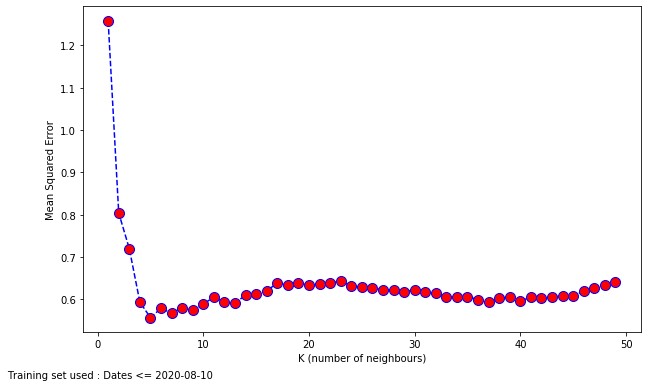

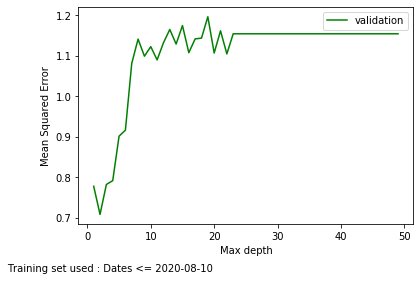

The mean squared error for KNN when data was split based on dates:  0.5563145262572391
The mean squared error for Decison Tree when data was split based on dates:  0.7827055864573822


In [88]:
#numpy array for features of the training data
x_date_train_array = merged_new_date[merged_new_date["date"] <= "2020-08-10"].values[:,2:-2].astype(float)
#numpy array for label of the training data
y_date_train_array = merged_new_date[merged_new_date["date"] <= "2020-08-10"].values[:,-1].astype(float)
#numpy array for features of the test data
x_date_test_array = merged_new_date[merged_new_date["date"] > "2020-08-10"].values[:,2:-2].astype(float) 
#numpy array for label of the test data
y_date_test_array = merged_new_date[merged_new_date["date"] > "2020-08-10"].values[:,-1].astype(float)

knn_elbow(x_date_train_array,x_date_test_array,y_date_train_array,y_date_test_array, "Dates <= 2020-08-10")
decision_tree_visualize(x_date_train_array,x_date_test_array,y_date_train_array,y_date_test_array, "Dates <= 2020-08-10")



#Optimal value of K given by the elbow curve above
model_knn = neighbors.KNeighborsRegressor(n_neighbors=5) 
model_knn = model_knn.fit(x_date_train_array,y_date_train_array)
prediction_knn = model_knn.predict(x_date_test_array)
mse_knn = mean_squared_error(y_date_test_array, prediction_knn)
print("The mean squared error for KNN when data was split based on dates: ", mse_knn)



#Optimal value of the max depth given by the graph above
model_tree = tree.DecisionTreeRegressor(max_depth=3,random_state = 0)
model_tree = model_tree.fit(x_date_train_array,y_date_train_array)
prediction_tree = model_tree.predict(x_date_test_array)
mse_tree = mean_squared_error(y_date_test_array, prediction_tree)
print("The mean squared error for Decison Tree when data was split based on dates: ", mse_tree)


## Cross Validation based on regions

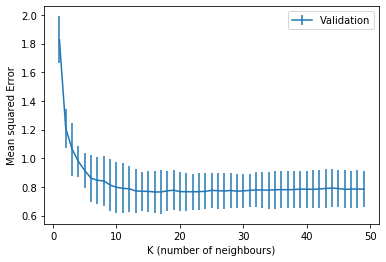

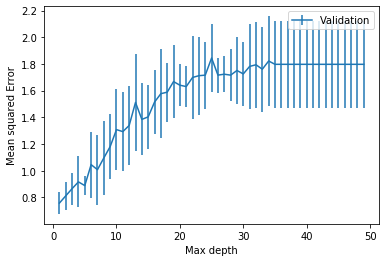

In [97]:
#Get all different regions in a list
regions_total = merged_new_region["open_covid_region_code"].value_counts().index.to_list() 
#Total number of regions
num_regions = len(regions_total)
#Number of regions that will be used in the training 
num_train = round(len(regions_total) * 0.8) 
#Number of regions that will be used in the validation
num_validation = num_regions - num_train



K_list = range(1,50)
H_list = range(1,50)
#5 is the number of folds
err_valid_knn = np.zeros((len(K_list), 5)) 
err_valid_tree = np.zeros((len(H_list), 5))


for j in range(5):
    regions = np.random.choice(regions_total,num_train,replace = False) 
    regions_train = merged_new_region.open_covid_region_code.isin(regions)
    x_regions_train_array = merged_new_region[regions_train].values[:,2:-2].astype(float) 
    y_regions_train_array = merged_new_region[regions_train].values[:,-1].astype(float) 
    regions_test = ~merged_new_region.open_covid_region_code.isin(regions)
    x_regions_test_array = merged_new_region[regions_test].values[:,2:-2].astype(float) 
    y_regions_test_array = merged_new_region[regions_test].values[:,-1].astype(float)
    
    #Apply the splitting to KNN
    for i, K in enumerate(K_list):
        
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        model = model.fit(x_regions_train_array,y_regions_train_array)
        err_valid_knn[i, j] = ((mean_squared_error(y_regions_test_array,model.predict(x_regions_test_array ))))
        
    #Apply the splitting to decision trees   
    for m, h in enumerate(H_list):
        model = tree.DecisionTreeRegressor(max_depth=h,random_state = 0)
        model = model.fit(x_regions_train_array,y_regions_train_array)
        err_valid_tree[m, j] = ((mean_squared_error(y_regions_test_array,model.predict(x_regions_test_array ))))
    
        
    
  
plt.errorbar(K_list, np.mean(err_valid_knn, axis=1), np.std(err_valid_knn, axis=1), label='Validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('Mean squared Error')
plt.show()    

plt.errorbar(H_list, np.mean(err_valid_tree, axis=1), np.std(err_valid_tree, axis=1), label='Validation')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Mean squared Error')
plt.show() 
    
    

## KNN and Decision Trees based on regions

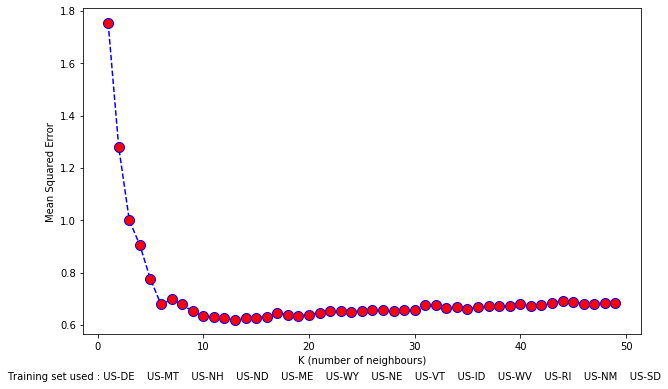

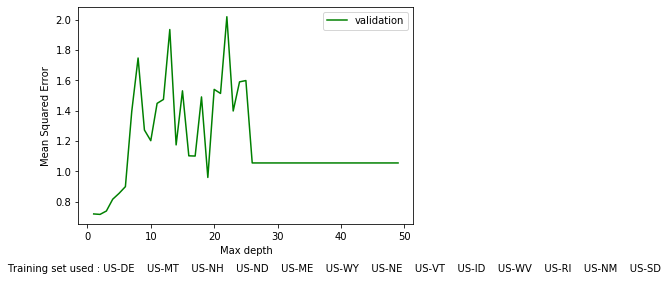

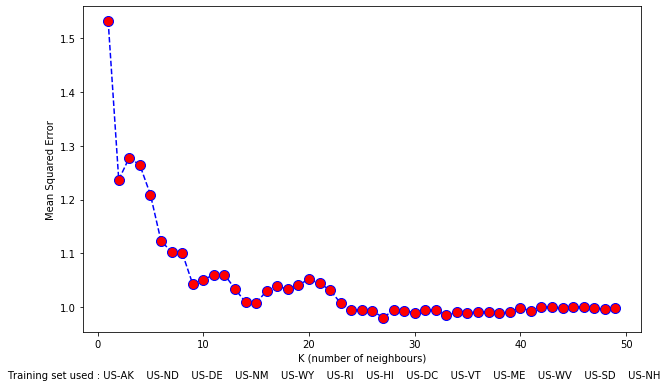

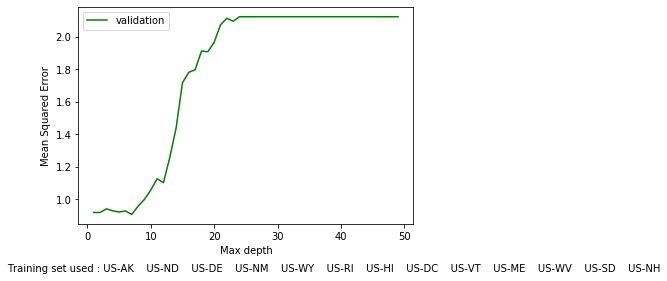

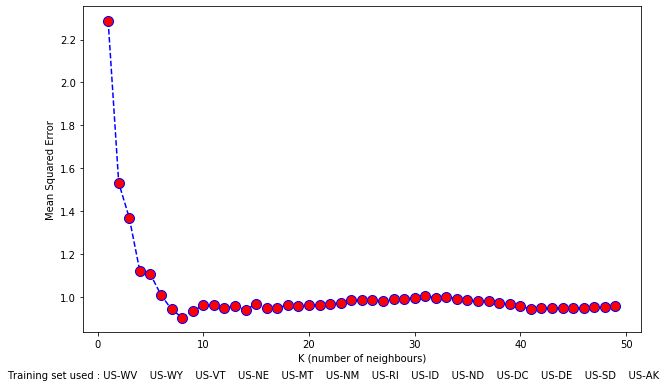

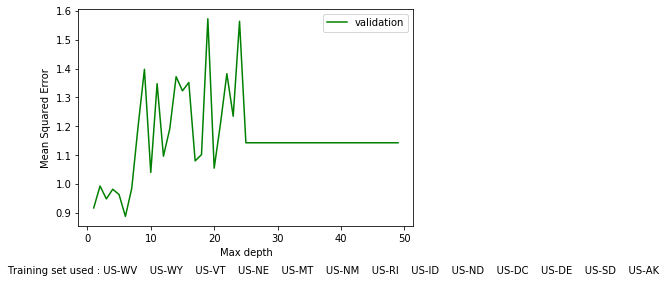

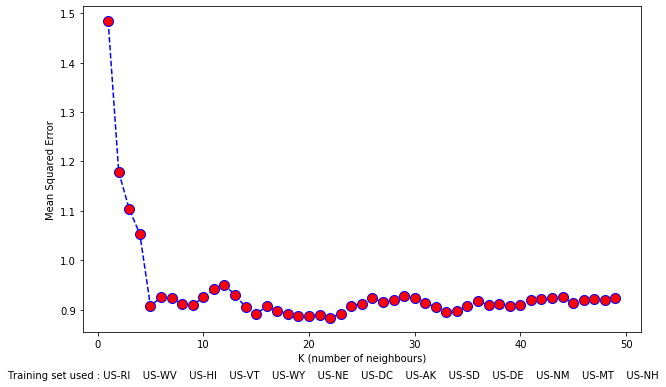

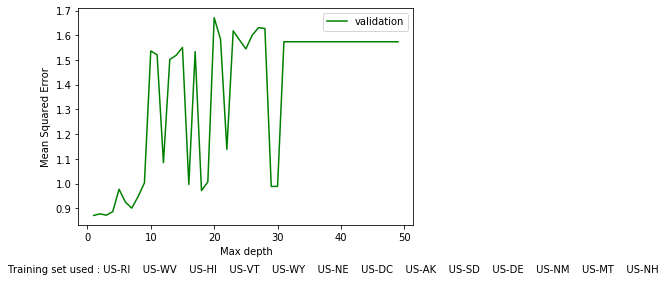

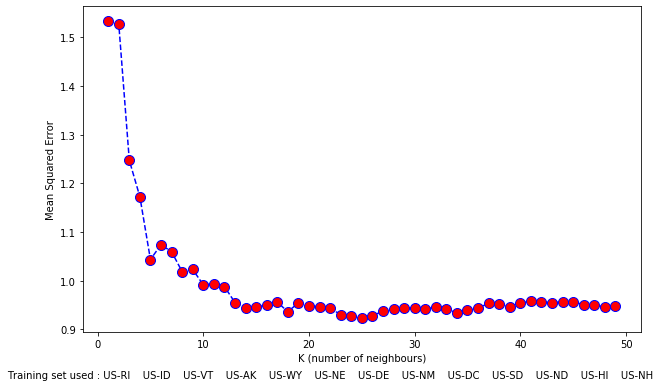

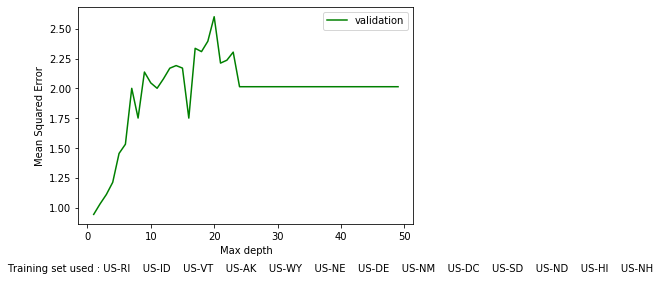

In [89]:
#Get all different regions in a list
regions_total = merged_new_region["open_covid_region_code"].value_counts().index.to_list() 
#Total number of regions
num_regions = len(regions_total)
#Number of regions that will be used in the training 
num_train = round(len(regions_total) * 0.8) 
#Number of regions that will be used in the validation
num_validation = num_regions - num_train

#Repeat the cross validation 5 times for more accuracy 
for i in range(5):
    #TA said that we can choose random values,just have to make sure that train and test data don't have the same values.
    regions = np.random.choice(regions_total,num_train,replace = False) #Choose 13 regions to train on 
    regions_train = merged_new_region.open_covid_region_code.isin(regions)
    #numpy array for features of the training data
    x_regions_train_array = merged_new_region[regions_train].values[:,2:-2].astype(float) 
    #numpy array for label of the training data
    y_regions_train_array = merged_new_region[regions_train].values[:,-1].astype(float) 
    regions_test = ~merged_new_region.open_covid_region_code.isin(regions)
    #numpy array for features of the test data
    x_regions_test_array = merged_new_region[regions_test].values[:,2:-2].astype(float) 
     #numpy array for label of the test data
    y_regions_test_array = merged_new_region[regions_test].values[:,-1].astype(float)
    knn_elbow(x_regions_train_array,x_regions_test_array,y_regions_train_array,y_regions_test_array, (' '*4).join(regions))
    decision_tree_visualize(x_regions_train_array,x_regions_test_array,y_regions_train_array,y_regions_test_array, (' '*4).join(regions))
    
   
   
      